# Notebook II: Training the Instance Segmentation CNN

This notebook is about estimating shape of instances (buildings). Here we design and train a neural network that detect shape of instances (buildings) from input RGB image patches of buildings (satellite images) with Vec2Instance architecture.

__Content of this notebook:__

    1) Reading and Exploring Data
    2) Designing the Neural Network
    3) Training and Prediction
    
__Dataset citation__: *SpaceNet on Amazon Web Services (AWS). “Datasets.” The SpaceNet Catalog. Last modified October 1st, 2018. https://spacenet.ai/datasets/*

<hr>
<hr>
<hr>

In [2]:
'''first importing libraries'''

import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, GaussianNoise, Lambda, Dropout
from keras import backend as K

import cv2

import glob
from random import shuffle
import numpy as np
from matplotlib import pyplot as plt
import imageio

import tensorflow as tf

### 1) Reading and Exploring Data

First, let's read __*building_satellite_images*__ and __*building_shapes*__ data (including training and test datasets). 

In [ ]:
'''Loading datasets'''

x_read = np.load('./data/building_satellite_images.npz')
y_read = np.load('./data/building_shapes.npz')

x_train = x_read['x_train'].astype(float)
x_test = x_read['x_test'].astype(float)
y_train = y_read['y_train'].astype(float)
y_test = y_read['y_test'].astype(float)

In [4]:
print(x_train.shape) # shape corresponding to: [Buildings, Height, Width, R/G/B]
print(y_train.shape) # shape corresponding to: [Buildings, Height, Width, Binary (building shape)]

(35075, 64, 64, 3)
(35075, 64, 64, 1)


In [5]:
print(x_test.shape) # shape corresponding to: [Buildings, Height, Width, R/G/B]
print(y_test.shape) # shape corresponding to: [Buildings, Height, Width, Binary (building shape)]

(18519, 64, 64, 3)
(18519, 64, 64, 1)


In the case of the instance segmentation CNN, each individual image patch corresponding to each building and its segmentation is provided to the network. __*building_satellite_images*__ data contains RGB satellite image patches centering on a single instance (buildings). And segmented instance of the corresponding instance (building) is provided in __*building_shapes*__ data.

All these patches are in shape of (64, 64) pixels. Hence, maximum building size that can be detected from this particular network is limited to (64, 64) pixels. In this dataset, we have removed data containing building larger than size of (64, 64) pixels. If required this can be increased while designing the network.

Let's visualize random impute and output image to see how it looks,

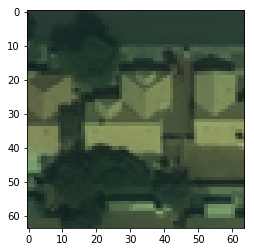

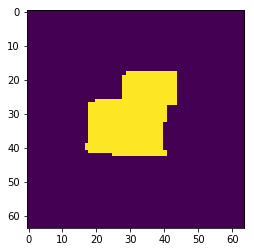

[0. 1.]


In [6]:
'''plot sample of training data'''

plt.imshow(x_train[25,:,:,0:3])
plt.show()

plt.imshow(y_train[25,:,:,0])
plt.show()

print(np.unique(y_train[25,:,:,0])) # printing unique values to make sure

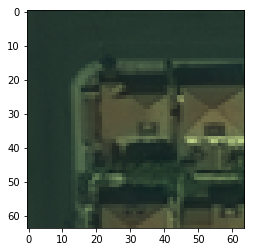

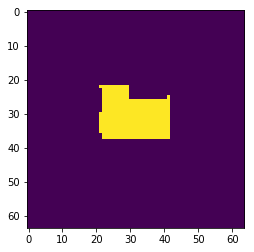

[0. 1.]


In [8]:
'''plot sample of test data'''

plt.imshow(x_test[15,:,:,0:3])
plt.show()

plt.imshow(y_test[15,:,:,0])
plt.show()

print(np.unique(y_test[25,:,:,0])) # printing unique values to make sure

### 2) Designing the Neural Network

Encoder is a typical CNN with Convolutional layers, Max pooling operations and Dropouts. Then middle vector of the output of the encoder is extracted. And it is rearranged as a vanilla neural network (MLP) producing output mask. This middle vector parametrize the shape of an instance (building). This parametrization idea is the core concept behind Vec2Instance architecture.

In [9]:
'''parameters of Vec2Instace parametrization'''

img_dim = 64 # input dimension 
out_var = 1 # output bands (single band for mask)
hidden_size = 64 # hidden size of vanilla neural network of Vec2Instace
num_param = (2*hidden_size + hidden_size) + (hidden_size*out_var + out_var) # total number of parameters in vanilla neural network of Vec2Instace 

'''Encoder Section'''

x_in = Input(shape=(None, None, 3)) # input shape: (height, width, 3 bands of RGB)
x_temp = Conv2D(32, (3, 3), activation='relu', padding='same')(x_in)
x_temp = Dropout(0.25)(x_temp)
x_temp = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_temp)
x_temp = Conv2D(32, (3, 3), dilation_rate=(2, 2), activation='relu', padding='same')(x_temp) # dilated convolutions
x_temp = Dropout(0.25)(x_temp)
x_temp = Conv2D(32, (3, 3), dilation_rate=(2, 2), activation='relu', padding='same')(x_temp) # dilated convolutions
x_temp = MaxPooling2D((2,2))(x_temp)
x_temp = Conv2D(64, (3, 3), dilation_rate=(2, 2), activation='relu', padding='same')(x_temp) # dilated convolutions
x_temp = Dropout(0.25)(x_temp)
x_temp = Conv2D(64, (3, 3), dilation_rate=(2, 2), activation='relu', padding='same')(x_temp) # dilated convolutions
x_temp = MaxPooling2D((2,2))(x_temp)
x_temp = Conv2D(64, (3, 3), dilation_rate=(2, 2), activation='relu', padding='same')(x_temp) # dilated convolutions
x_temp = Dropout(0.25)(x_temp)
x_temp = Conv2D(64, (3, 3), dilation_rate=(2, 2), activation='relu', padding='same')(x_temp) # dilated convolutions

x_temp = Conv2D(64, (1, 1), activation='relu', padding='same')(x_temp)
x_temp = Conv2D(64, (1, 1), activation='relu', padding='same')(x_temp)
x_cnn = Conv2D(num_param, (1, 1), activation='linear', padding='same')(x_temp) # output bands are corresponding to number of parameters in vanilla neural network (MLP) of Vec2Instace.

'''Extracting the vector at the middle from the output of the encoder. This vector parametrize the shape of an instance'''

def get_middle_param(arg_in):
    mid_idx = tf.shape(arg_in)[1]/2
    dec_para = arg_in[:, K.cast(mid_idx,"int32"), K.cast(mid_idx,"int32"), :]    
    return dec_para

'''rearranging the vector at the middle as vanilla neural network (MLP) of Vec2Instace'''

def decorder2D(arg_in):
    
    dec_size = tf.shape(arg_in)[0]
    
    # creating input of vanilla neural network (x and y coordinates)
    xx, yy = tf.meshgrid(tf.range(-img_dim/2, img_dim/2), tf.range(-img_dim/2, img_dim/2))
    xx = K.transpose(K.flatten(tf.to_float(xx)))
    yy = K.transpose(K.flatten(tf.to_float(yy)))
    xx_yy_stack = K.stack((xx, yy), axis=1)
    lyr_in = K.tile( K.reshape(xx_yy_stack, (1,img_dim*img_dim,2)), (dec_size,1,1))
    
    # vanilla neural network (MLP)
    lyr_hidden_wgt = K.stack( (arg_in[:, 0:hidden_size],arg_in[:, hidden_size*1:hidden_size*2]), axis=1)
    lyr_hidden_b = tf.matmul(tf.ones((dec_size,img_dim*img_dim,1)), K.reshape(arg_in[:,hidden_size*2:hidden_size*3], (dec_size,1,hidden_size)))
    lyr_hidden_out = K.tanh( tf.matmul(lyr_in, lyr_hidden_wgt) +  lyr_hidden_b) 
    
    lyr_out_wgt = K.reshape( arg_in[:, hidden_size*3:hidden_size*(3+out_var)], (dec_size,hidden_size,out_var))
    lyr_out_b = tf.matmul(tf.ones((dec_size,img_dim*img_dim,1)), K.reshape(arg_in[:, hidden_size*(3+out_var):hidden_size*(3+out_var)+out_var], (dec_size,1,out_var)))
    lyr_out = K.sigmoid( tf.matmul(lyr_hidden_out, lyr_out_wgt) + lyr_out_b ) 

    lyr_out_img = K.reshape( lyr_out, (dec_size,img_dim,img_dim,out_var))
    
    return lyr_out_img

x_temp = Lambda(get_middle_param)(x_cnn)
x_out = Lambda(decorder2D)(x_temp)

model = Model(inputs=x_in, outputs=x_out)

model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam()) # setting loss and optimizer

model.summary() # printing the model summary

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 32)    896       
_________________________________________________________________
dropout_1 (Dropout)          (None, None, None, 32)    0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 32)    9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, None, None, 32)    0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 32)    9248      
_________________________________________________________________
dropout_2 (Dropout)          (None, None, None, 32)    0         
__________

__Key idea of Vec2Instance architecture is as below,__

- an instance mask is a multivariate function in two dimensions. The input to the multivariate function is a pixel location (x and y coordinate values), and the output of the multivariate function should be 1 if the location is inside the mask and 0 otherwise.
- this function can be approximated by an vanilla neural network (MLP). And the weights and biases of this vanilla neural network (MLP) can be considered as parameters that represent an instance mask (building shape). This idea can be seen in below figure.

<img src="./graphics/Vec2Instance_and_VanilaNN.png" alt="Multivariate function vs. vanilla neural network for Vec2Instance" width="70%"/>

- Now, we have a way to parametrize an instance mask. Then, a CNN can be used to learn those parameters and then those parameters can be re-arranged as weights and biases of vanilla neural network (MLP). And this vanilla neural network (MLP) applied on pixel coordinates centered at the centroid of each instance, outputting instance mask (building shape) for each instance, as in below figure.

<img src="./graphics/Vec2Instance_CNN_Arch.PNG" alt="Vec2Instance architecture" width="70%"/>

### 3) Training and Prediction

In [ ]:
'''training the model'''

batch_size = 500
epochs = 1000

fit_h = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0, shuffle=1, validation_data=(x_test,y_test))

*Note: set verbose=1 to see training progress for each epoch. Single epoch takes 15s in single NVIDIA GTX 1080 Ti GPU.*

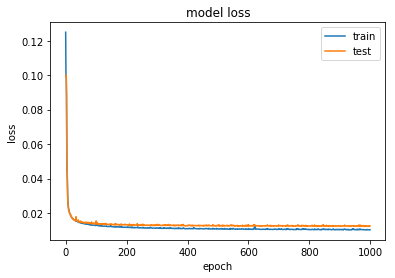

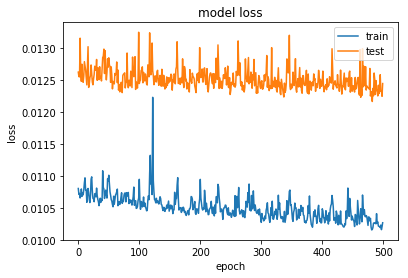

In [11]:
'''plotting loss curves'''

# plotting all 1000 epochs
plt.plot(fit_h.history['loss'])
plt.plot(fit_h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# plotting last 500 epochs
plt.plot(fit_h.history['loss'][500:])
plt.plot(fit_h.history['val_loss'][500:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [12]:
'''saving the model'''

model_save = Model(inputs=x_in, outputs=x_cnn)

model_json = model_save.to_json()
with open("./models/InsSeg_Encoder.json", "w") as json_file:
    json_file.write(model_json)

model_save.save_weights("./models/InsSeg_Encoder.h5")

In [13]:
'''prediction over the training/test dataset from the trained model '''

yp_train = model.predict(x_train, batch_size=batch_size)
print(yp_train.shape);

yp_test = model.predict(x_test, batch_size=batch_size)
print(yp_test.shape);

(35075, 64, 64, 1)
(18519, 64, 64, 1)


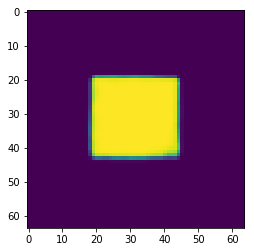

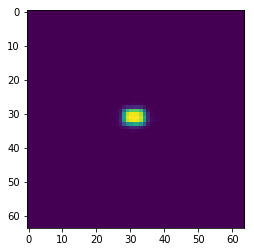

In [14]:
'''plot couple of predictions to see how it comes'''

plt.imshow(yp_train[181,:,:,0], vmin=0, vmax=1)
plt.show()

plt.imshow(yp_test[181,:,:,0], vmin=0, vmax=1)
plt.show()